# Wikipedia Talk Data - Getting Started

This notebook gives an introduction to working with the various data sets in [Wikipedia
Talk](https://figshare.com/projects/Wikipedia_Talk/16731) project on Figshare. The release includes:

1. a large historical corpus of discussion comments on Wikipedia talk pages
2. a sample of over 100k comments with human labels for whether the comment contains a personal attack
3. a sample of over 100k comments with human labels for whether the comment has aggressive tone

Please refer to our [wiki](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) for documentation of the schema of each data set and our [research paper](https://arxiv.org/abs/1610.08914) for documentation on the data collection and modeling methodology. 

In this notebook we show how to build a simple classifier for detecting personal attacks and apply the classifier to a random sample of the comment corpus to see whether discussions on user pages have more personal attacks than discussion on article pages.

## Building a classifier for personal attacks
In this section we will train a simple bag-of-words classifier for personal attacks using the [Wikipedia Talk Labels: Personal Attacks]() data set.

In [1]:
#Using Python 3
import pandas as pd
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import os
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

path_comment = os.path.isfile(os.path.join(os.getcwd(),'attack_annotated_comments.tsv'))
path_annotate = os.path.isfile(os.path.join(os.getcwd(),'attack_annotations.tsv'))

# To download only once, and not download it later                
if not os.path.isfile(path_comment):
    download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
if not os.path.isfile(path_annotate):
    download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [3]:
#Populate the dataframes
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [4]:
len(annotations['rev_id'].unique())

115864

In [5]:
# To visualize the data format
comments.head(10)

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train
102817,NEWLINE_TOKEN-NEWLINE_TOKENNEWLINE_TOKENImport...,2002,True,user,random,train
103624,I removed the following:NEWLINE_TOKENNEWLINE_T...,2002,True,article,random,train
111032,`:If you ever claimed in a Judaic studies prog...,2002,True,article,random,dev
120283,NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENMy apol...,2002,True,article,random,dev


In [6]:
annotations['attack'].unique()

array([0., 1.])

In [7]:
# To visualize the data format
annotations.head(10)

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0
5,37675,176,0.0,0.0,0.0,0.0,0.0
6,37675,481,0.0,0.0,0.0,0.0,0.0
7,37675,487,0.0,0.0,0.0,0.0,0.0
8,37675,578,0.0,0.0,0.0,0.0,0.0
9,37675,1127,0.0,0.0,0.0,0.0,0.0


In [8]:
# labels a comment as an atack if the majority of annotators did so
labels = annotations.groupby('rev_id')['attack'].mean() > 0.7

In [9]:
#labels = annotations.groupby('rev_id')['attack'].median() > 0.5

In [10]:
# join labels and comments
comments['attack'] = labels

In [11]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
#Remove punctuations
string.punctuation
def remove_punct(text):
    text  = "".join([c for c in text if c not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
# Apply the method on comment and remove punctuations
comments['comment'] = comments['comment'].apply(lambda x: remove_punct(x))

In [12]:
#To check the clean data
pd.set_option('display.max_colwidth', 10000)
comments.head(10)

comment  \
rev_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

### To validate if nulls are present in data and clean them up

In [13]:
# To check if any value is null
annotations.isnull().values.any()
comments.isnull().values.any()

False

In [14]:
comments.describe()

,year
count,115864.000000
mean,2009.224306
std,2.900431
min,2001.000000
25%,2007.000000
50%,2009.000000
75%,2011.000000
max,2016.000000


In [15]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115864 entries, 37675 to 699897151
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   comment    115864 non-null  object
 1   year       115864 non-null  int64 
 2   logged_in  115864 non-null  bool  
 3   ns         115864 non-null  object
 4   sample     115864 non-null  object
 5   split      115864 non-null  object
 6   attack     115864 non-null  bool  
dtypes: bool(2), int64(1), object(4)
memory usage: 5.5+ MB


In [16]:
#Shows that classes are imbalanced
comments['attack'].value_counts()

False    107190
True       8674
Name: attack, dtype: int64

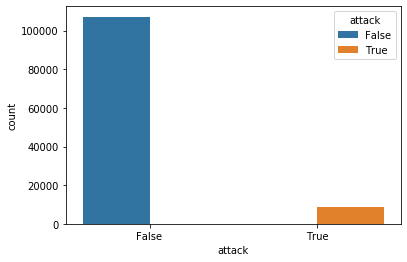

In [17]:
#displays the imbalance in the data
ax = sns.countplot(x="attack", hue="attack",data=comments)

In [18]:
from sklearn.utils import resample

# Separate majority(attack = False) and minority(attack = True) class
majority = comments[comments.attack==0]
minority = comments[comments.attack==1]
 
# Upsample minority class
minority_upsampled = resample(minority, 
                                 replace=True,     # Do resampling with replacement
                                 n_samples=107190,    # Number same as majority class to ensure they balance
                                 random_state=11)
 
# Combine majority class with upsampled minority class to generate dataframe with balanced class values
upsampled = pd.concat([majority, minority_upsampled])
 
# Display new class counts
upsampled.attack.value_counts()
# Reset to the comments dataframe
comments = upsampled

### Case 1: Using Train and Test split based on the column value 
(Consider only Comment as Feature)

In [19]:
#Train and Test split
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")
X_train = train_comments['comment']
y_train = train_comments['attack']
X_test = test_comments['comment']
y_test = test_comments['attack']


#### Model : Using Tf-idf Vectorizer  and Linear SVC (Selecting the model - Final)
For the Vectorizer : used cleaned comments and further remove the stop words.
Hyper Tuned parameters like ngram range
Result Accuracy = 0.96


In [20]:
''' For imbalanced data: Performance is:

precision    recall  f1-score   support

       False       0.97      0.99      0.98     21385
        True       0.85      0.63      0.72      1793

    accuracy                           0.96     23178
   macro avg       0.91      0.81      0.85     23178
weighted avg       0.96      0.96      0.96     23178

Accuracy: 0.9626801277073087'''
from sklearn.svm import LinearSVC
clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('clf', LinearSVC(random_state=87,C=1.5,max_iter = 1871))
])

clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
met= metrics.classification_report(y_test, y_predict)
print(met)
print("Accuracy:", accuracy_score(y_test, y_predict))

              precision    recall  f1-score   support

       False       0.80      0.96      0.88     21385
        True       0.96      0.77      0.85     22123

    accuracy                           0.87     43508
   macro avg       0.88      0.87      0.86     43508
weighted avg       0.88      0.87      0.86     43508

Accuracy: 0.8653351107842235


[[20615   770]
 [ 5089 17034]]


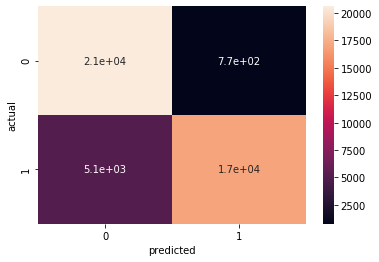

In [21]:
print(metrics.confusion_matrix(y_test, clf.predict(X_test), labels=[False,True]))
sns.heatmap(metrics.confusion_matrix(y_test, clf.predict(X_test), labels=[False, True]), annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

### Case 2: Train and Test split by randomizing/shuffling and stratification
Stratification ensures to preserving the percentage of samples for each class.
Comment is considered as Feature

In [22]:
from sklearn.model_selection import train_test_split
# Take the comments as X
X_df = comments.comment
# Take the attack as class value
y_df = comments["attack"]
#Split into test-train data, ensuring shuffling and stratification
X_train_df, X_test_df,y_train_df, y_test_df = train_test_split(X_df,y_df,test_size=0.3,random_state = 131, shuffle = True, stratify=y_df)

In [23]:
''' For imbalanced data: Performance is:
precision    recall  f1-score   support

       False       0.97      0.99      0.98     32158
        True       0.83      0.66      0.73      2602

    accuracy                           0.96     34760
   macro avg       0.90      0.82      0.86     34760
weighted avg       0.96      0.96      0.96     34760

Accuracy: 0.9643268124280783'''

# Model Generation for balanced dataset

clf_4 = Pipeline([('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('clf', LinearSVC(random_state=87,C=1.5,max_iter = 1871))
])
clf_4 = clf_4.fit(X_train_df, y_train_df)
y_predict_4 = clf_4.predict(X_test_df)
met_4 = metrics.classification_report(y_test_df, y_predict_4)
print(met_4)
print("Accuracy:", accuracy_score(y_test_df, y_predict_4))

              precision    recall  f1-score   support

       False       0.99      0.95      0.97     32157
        True       0.95      0.99      0.97     32157

    accuracy                           0.97     64314
   macro avg       0.97      0.97      0.97     64314
weighted avg       0.97      0.97      0.97     64314

Accuracy: 0.9687315359019809


[[20658   727]
 [  165 21958]]


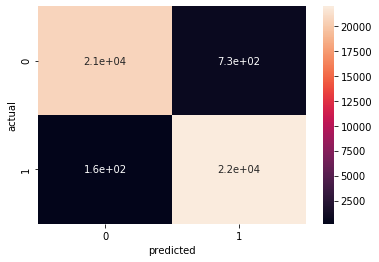

In [24]:
print(metrics.confusion_matrix(test_comments['attack'], clf_4.predict(test_comments['comment']), labels=[False,True]))
sns.heatmap(metrics.confusion_matrix(test_comments['attack'], clf_4.predict(test_comments['comment']), labels=[False, True]), annot=True)
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()

In [25]:
# correctly classify nice comment
clf_4.predict(['Thanks for you contribution, you did a great job!'])

array([False])

In [26]:
clf_4.predict(['You are a good person!!!!'])

array([False])

In [27]:
# correctly classify nasty comment
clf_4.predict(['People as stupid as you should not edit Wikipedia!'])

array([ True])

In [28]:
clf_4.predict(['You are an idiot!'])

array([ True])

# Report:

Using Python 3 version

## Step 1: Analyzing the dataset:
The dataset contains various columns/features like - comment, year, logged_in, ns,sample, split
Class = attack (Type= boolean, False = not a personal attack, good comment; True = Personal attack, bad comment)

## Step 2: Data Cleaning:
The comment is user-defined. Thus, will have a lot of slang, punctuations, typos, extra spaces, etc.
Thus, we need to clean the data. 'Comment' feature is the most important feature to decide if it's a personal attack or not.

**Following cleaning steps are carried out:**
1. Removing NewLine Token
2. Removing TabToken 
3. Removing Punctuations
4. Removing Stop words (done on vectorizer)
5. Removing english accent words.
6. Check for NaN or None (No null or NaN found)

All these are included in the final code.

## Step 3: Feature Selection and Feature Extraction
The most important Feature is 'comment'. Apart from comment I considered year and ns features too. However, they didn't contribute much to improve the performance and took a lot of run time. Thus, in my final code model, I have considered **'comment' as the only feature.**

To use 'attack' information from different annotators I tried the following:
1. Average and use threshold = 0.5
2. Median and use threshold = 0.5 (Doesn't lead to significant improvement)
3. Average and use threshold = 0.6 (Choosen)

## Step 4: Optimizations
I have included few optimizations -removing stop words and accents while performing Tf-idf vectorization. This ensures more cleaner data and TFIDF Vectorizer is more better as stop words are removed.

## Step 5: Preparing Train and Test data

**Part 1: Handling imbalanced data**
In Step 1, I found out that the data is imbalanced.
False    107190
True       8674
Name: attack, dtype: int64

Thus, to get better performance, before applying the models, we make the data balanced(Used: from sklearn.utils import resample). This is very crucial as it will avoid model to be overfit or underfit.

**Part 2: Randomizing and Stratifing the data**
1. I tried to build model using the test and train label dataset. However, found that random split works better.
2. Holdout Estimate method: This splits data into 70-30% (User defined)split. This is good as it is shuffled and stratified.



## Step 6: Try Models

Various Models were tried for combinations of different test-train datasets. (Without balancing the data)


**Given Model/BaseLine**
train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")

clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', DecisionTreeClassifier(random_state = 123)),
])
clf = clf.fit(train_comments['comment'], train_comments['attack'])

met = metrics.classification_report(test_comments['attack'], clf.predict(test_comments['comment']))
print(met)

     precision    recall  f1-score   support

       False       0.95      0.95      0.95     20422
        True       0.63      0.61      0.62      2756

    accuracy                           0.91     23178
   macro avg       0.79      0.78      0.79     23178
weighted avg       0.91      0.91      0.91     23178

**Method 1: TF-idf and Gaussian NB:** (Discarded)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import GaussianNB

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('to_dense', DenseTransformer()), 
    ('clf', GaussianNB())
])

clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
met= metrics.classification_report(y_test, y_predict)
print(met)
print("Accuracy:", accuracy_score(y_test, y_predict))


              precision    recall  f1-score   support

       False       0.95      0.53      0.68     20422
        True       0.19      0.81      0.31      2756

    accuracy                           0.56     23178
   macro avg       0.57      0.67      0.49     23178
weighted avg       0.86      0.56      0.64     23178

**Accuracy: 0.5633359219949953**

**Model 2: Using Tf-idf Vectorizer and Logistic Regression**(Discarded)

model_2 = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('clf', LogisticRegression(random_state=0,max_iter = 865423))
])

model_2 = model_2.fit(X_train, y_train)
y_predict = model_2.predict(X_test)
met= metrics.classification_report(y_test, y_predict)
print(met)
print("Accuracy:", accuracy_score(y_test, y_predict))


              precision    recall  f1-score   support

       False       0.94      0.99      0.97     20422
        True       0.92      0.56      0.70      2756

    accuracy                           0.94     23178
   macro avg       0.93      0.78      0.83     23178
weighted avg       0.94      0.94      0.94     23178

**Accuracy: 0.9416688238847183**

**Model 3: Using Tf-idf Vectorizer and MultinomialNB**(Discarded)

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.naive_bayes import MultinomialNB

class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()


clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('to_dense', DenseTransformer()), 
    ('clf', MultinomialNB(alpha =0.5))
])

clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
met= metrics.classification_report(y_test, y_predict)
print(met)
print("Accuracy:", accuracy_score(y_test, y_predict))

             precision    recall  f1-score   support

       False       0.93      0.99      0.96     20422
        True       0.92      0.49      0.64      2756

    accuracy                           0.93     23178
   macro avg       0.93      0.74      0.80     23178
weighted avg       0.93      0.93      0.92     23178

**Accuracy: 0.934075416343084**

**Model 4: Using Tf-idf Vectorizer and LinearSVC**(Accepted as model)

from sklearn.svm import LinearSVC
#('clf', LinearSVC(random_state=87,C=0.5,max_iter = 1871))
clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('clf', LinearSVC(random_state=87,C=1.5,max_iter = 1871))
])

clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
met= metrics.classification_report(y_test, y_predict)
print(met)
print("Accuracy:", accuracy_score(y_test, y_predict))

              precision    recall  f1-score   support

       False       0.95      0.99      0.97     20422
        True       0.86      0.65      0.74      2756

    accuracy                           0.95     23178
   macro avg       0.91      0.82      0.86     23178
weighted avg       0.94      0.95      0.94     23178

**Accuracy: 0.9464578479592717**

## After balancing the imbalance data, model performances are as follows:

**1. Test and train is as per column value**
#Train and Test split

train_comments = comments.query("split=='train'")
test_comments = comments.query("split=='test'")
X_train = train_comments['comment']
y_train = train_comments['attack']
X_test = test_comments['comment']
y_test = test_comments['attack']

from sklearn.svm import LinearSVC
#('clf', LinearSVC(random_state=87,C=0.5,max_iter = 1871))
clf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('clf', LinearSVC(random_state=87,C=1.5,max_iter = 1871))
])

clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
met= metrics.classification_report(y_test, y_predict)
print(met)
print("Accuracy:", accuracy_score(y_test, y_predict))


               precision    recall  f1-score   support

       False       0.80      0.96      0.88     21385
        True       0.96      0.77      0.85     22123

    accuracy                           0.87     43508
   macro avg       0.88      0.87      0.86     43508
weighted avg       0.88      0.87      0.86     43508

**Accuracy: 0.8653351107842235**

**Please note the value decreases since the data is not well shuffled between train and test after resampling**

**2. Test and train is as per Holdout Estimate method(70% train, 30% test)**

from sklearn.model_selection import train_test_split
#Take the comments as X
X_df = comments.comment
#Take the attack as class value
y_df = comments["attack"]
#Split into test-train data, ensuring shuffling and stratification
X_train_df, X_test_df,y_train_df, y_test_df = train_test_split(X_df,y_df,test_size=0.3,random_state = 131, shuffle = True, stratify=y_df)


clf_4 = Pipeline([('tfidf', TfidfVectorizer(max_features = 10000, ngram_range = (1,1),norm = 'l2',analyzer ='word', lowercase = True, stop_words ={'english'}, strip_accents = 'ascii')),
    ('clf', LinearSVC(random_state=87,C=1.5,max_iter = 1871))
])
clf_4 = clf_4.fit(X_train_df, y_train_df)
y_predict_4 = clf_4.predict(X_test_df)
met_4 = metrics.classification_report(y_test_df, y_predict_4)
print(met_4)
print("Accuracy:", accuracy_score(y_test_df, y_predict_4))


             precision    recall  f1-score   support

       False       0.99      0.95      0.97     32157
        True       0.95      0.99      0.97     32157

    accuracy                           0.97     64314
   macro avg       0.97      0.97      0.97     64314
weighted avg       0.97      0.97      0.97     64314

**Accuracy: 0.9687315359019809**

This is the Final model.


## Step 7: Learning from different metrics

In this case, since the classes are imbalanced, thus, precision-recall is a good performance measure.
Precision is a measure of result relevancy. Recall is a measure of how many truly relevant results are returned.
F1 score/F measure combines the precision and recall information.(Harmonic mean)
Support is the number of actual occurrences of the class. - In this case, the support values show that there is data imbalance (possible cause of having lower value for 'True' class - *when model and evaluations are done without balancing the data).

## Step 8: Improvements with Cross-Validation
Yes, I tried cross-validation. However, it doesn't make significant improvement (since the train-test data was also shuffled already) in performance metrics (compared to final model) and consumed more time.

Ex: Tried Stratified K-Fold and RepeatedStratifiedKFold (both give almost similar accuracy as Hold-out estimate method )

from sklearn.model_selection import cross_val_score 
from sklearn.metrics import classification_report, accuracy_score, make_scorer 
from sklearn.model_selection import RepeatedStratifiedKFold 
originalclass = [] 
predictedclass = [] 
X_df = comments.comment 
y_df = comments["attack"]

#Generate classification report 
def classification_report_with_accuracy_score(y_true, y_pred): 
    originalclass.extend(y_true) 
    predictedclass.extend(y_pred) 
    return accuracy_score(y_true, y_pred) # return accuracy score

outer_cv = RepeatedStratifiedKFold(n_splits=13, random_state= 1381, n_repeats = 5)

clf = Pipeline([ ('tfidf', TfidfVectorizer(stop_words ={'english'}, strip_accents = 'ascii',ngram_range = (1,1))), ('clf', LinearSVC()) ])

nested_score = cross_val_score(clf, X_df, y_df, cv=outer_cv, scoring=make_scorer(classification_report_with_accuracy_score)) 
print(classification_report(originalclass, predictedclass)) 
print("Accuracy:", accuracy_score(originalclass, predictedclass))


## Step 9: Final Result Metrics
The best result is found when data is cleaned, balanced, test and train data is randomly split and **model used is : Tf-idf Vectorizer and LinearSVC**
Compared to strawman figure the performance is improved from **91% to 97% accuracy**


## Most intersting things learned
User data like comments in this case can be vague. Thus, to get better analysis, a lot of factors play role.
Data cleaning, Feature extraction, getting data split well such that class distribution is maintained (shuffling, stratification), choosing the model, hypertuning the parameters and performance evaluation.
Each step is equally important to get the best fit.


## Hardest thing to do
There are lot of factors in getting a better model. Data cleaning, Features, ML model used, different ways to split data, hyperparameters, etc. Thus, there was lot of time spend on trying to understand which combination works best.
Sometimes, making the model complex increases runtime but doesn't change the performance. This was crucial in understanding and deciding upon which model to choose.